# Detección de anomalías y explicabilidad de modelos con valores SHAP

#### Tabla de Contenidos

1) Importar dependencias, definir los parámetros y explorar los datos.

2) Detección de anomalías

3) Explicabilidad de modelos

## 1) Importar dependencias, explorar los datos y definir los parámetros

In [ ]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.21.0.33.21
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread      

In [ ]:
!pip install shap

Importo las dependencias necesarias.

In [ ]:
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import shap
from IPython import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

shap.initjs()

Defino parámetros de semilla y el estilo de los graficos y los valores de punto flotante.

In [ ]:
sns.set_style("ticks")
sns.set_context("paper")

seed = 1234
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

Cargo el conjunto de datos desde el repo de Github
. En este caso usaremos el mismo que para la clase de XGBoost, el [Adult de la UCI](https://archive.ics.uci.edu/ml/datasets/Adult).


In [ ]:
data = pd.read_csv("https://github.com/palasatenea66/DATASETS/raw/main/adult_train.csv")
#data.to_csv("adult_train.csv", index = False)
data

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
# asignar nombres correctos a las columnas
data.columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'target']

In [ ]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Analizo los datos, comenzando por los primeros registros y siguiendo por la distribución de las variables cuantitativas y la variable objetivo.

In [ ]:
data.describe().astype(int)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561,32561,32561,32561,32561,32561
mean,38,189778,10,1077,87,40
std,13,105549,2,7385,402,12
min,17,12285,1,0,0,1
25%,28,117827,9,0,0,40
50%,37,178356,10,0,0,40
75%,48,237051,12,0,0,45
max,90,1484705,16,99999,4356,99


La variable objetivo `target` define si una persona tenía un ingreso anual superior a los 50 mil dólares estadounidenses al momento de ser relevada la información.

In [ ]:
data.target.value_counts()

,count
target,
<=50K,24720
>50K,7841


In [ ]:
data.target.value_counts(normalize=True).round(2)

,proportion
target,
<=50K,0.76
>50K,0.24


Reemplazamos las categorías de la variable objetivo por valores binarios.

Normalizamos los datos utilizando la estandarización de `scikit-learn`

In [ ]:
numeric_data = data[["education-num", "capital-gain", "capital-loss", "hours-per-week"]]

In [ ]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(numeric_data),
                           columns = numeric_data.columns)

## 2) Detección de anomalías

Para tener una primera aproximación es útil estandarizar el conjunto de datos -las variables cuantitativas- y graficarlas usando un _boxplot_. Así, podemos tener rápidamente una idea de la cardinalidad de las variables y la cantidad de _outliers_ potenciales, a quienes podemos definir como puntos por fuera de los "bigotes" del _boxplot_. Si lo pensamos en términos de desvíos estándar, en este caso los "bigotes" comprenden 3 desvíos para sólo graficar por fuera puntos que están realmente lejos.

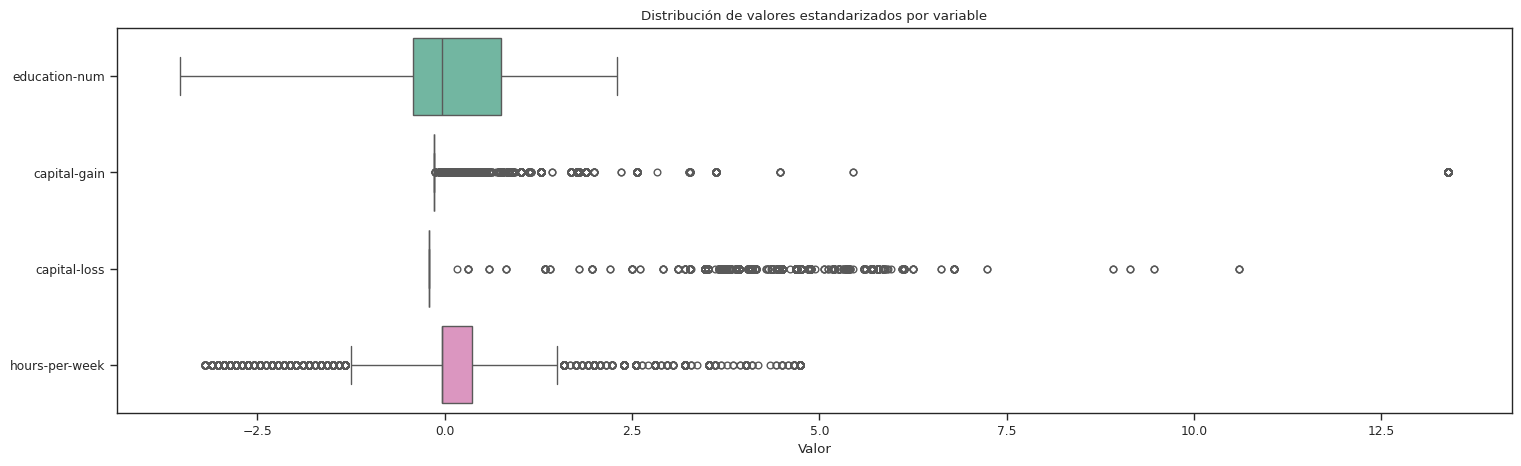

In [ ]:
data_boxplot = sns.boxplot(data = scaled_data, orient = "h", palette = "Set2", whis = 3)
plt.title("Distribución de valores estandarizados por variable")
plt.xlabel("Valor")
data_boxplot.figure.set_size_inches(18,5)

Para analizar los _outliers_ puedo evaluar cuántos puntos se ubican a más de 3 veces el rango intercuartil (IQR) con una técnica conocida como [Tukey's fences](https://en.wikipedia.org/wiki/Outlier#Tukey%27s_fences). Si bien estos puntos son probablemente _outliers_, siempre es importante tener en cuenta el dominio de análisis.

Para facilitar el análisis -y no tener que hacerlo nosotros- vamos a utilizar el mismo conjunto de datos pero tomándolo desde su versión previamente categorizada en la librería `shap`.

In [ ]:
numeric_data,y = shap.datasets.adult()

In [ ]:
numeric_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [ ]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32561 non-null  float32
 1   Workclass       32561 non-null  int8   
 2   Education-Num   32561 non-null  float32
 3   Marital Status  32561 non-null  int8   
 4   Occupation      32561 non-null  int8   
 5   Relationship    32561 non-null  int64  
 6   Race            32561 non-null  int8   
 7   Sex             32561 non-null  int8   
 8   Capital Gain    32561 non-null  float32
 9   Capital Loss    32561 non-null  float32
 10  Hours per week  32561 non-null  float32
 11  Country         32561 non-null  int8   
dtypes: float32(5), int64(1), int8(6)
memory usage: 1.1 MB


In [ ]:
numeric_data.shape

(32561, 12)

## Explicabilidad de modelos

Uno de los libros más relevantes para profundizar en el dominio de la interpretabilidad es [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) de Christoph Molnar. Allí se enumeran distintos tipos de interpretaciones que se pueden categorizar en 3 grupos:

1) Modelos interpretables
- Regresión lineal, logística, modelos lineales generalizados, árboles
2) Métodos agnósticos de los modelos
- PDP, ICE, ALE, Feature Importance, modelos surrogados, LIME, SHAP
3) Explicaciones basadas en ejemplos
- Contrafácticas, adversarias

#### Creación del conjunto para entrenar
Vamos a cargar el mismo conjunto de datos pero desde la librería `SHAP`

In [ ]:
X,y = shap.datasets.adult()

X_display,y_display = shap.datasets.adult(display=True)

Dividimos en entrenamiento y validación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#### Entrenamiento de modelo de extreme gradient boosting (XGBoost)

La técnica de XGBoost fue explicada en clases anteriores. Aquí modelaremos usando un conjunto no optimizado de hiperparámetros, con cien iteraciones y _early stopping_.

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}

model_xgboost = xgb.train(params, dtrain, 1000, evals = [(dtest, "test")],
                          verbose_eval=100, early_stopping_rounds=100)

[0]	test-logloss:0.54183
[100]	test-logloss:0.36783
[200]	test-logloss:0.32489
[300]	test-logloss:0.30919
[400]	test-logloss:0.30159
[500]	test-logloss:0.29744
[600]	test-logloss:0.29488
[700]	test-logloss:0.29329
[800]	test-logloss:0.29229
[900]	test-logloss:0.29176
[999]	test-logloss:0.29143


#### Feature importance

Antes de evaluar los valores Shapley utilizando la librería `SHAP` analizaremos la métrica de importancia de atributos con la que cuenta XGBoost. Hay tres maneras de evaluarla: peso (weight), ganancia (gain) y cobertura (coverage).

1) El peso refiere a la cantidad de veces que un atributo aparece en un árbol.

2) La ganancia representa a la ganancia promedio de los cortes que utilizan el atributo.

3) La cobertura refiere a la cobertura -cantidad de registros afectados- promedio de las divisiones que usan el atributo.

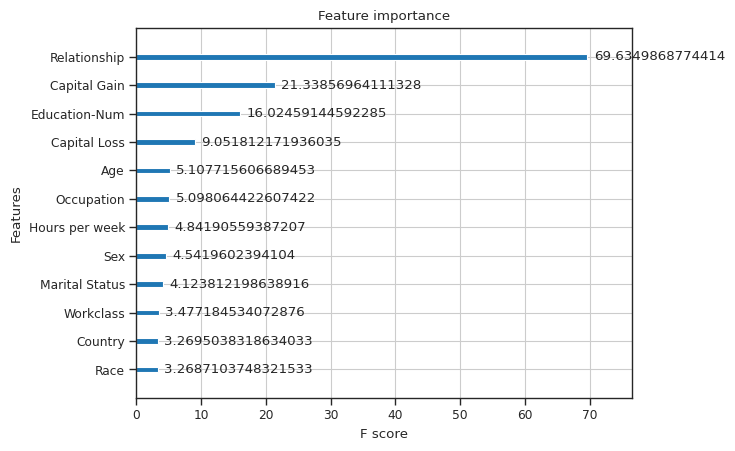

In [ ]:
xgb.plot_importance(model_xgboost, importance_type="gain")
plt.show()

### SHAP

La librería [`SHAP`( SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html) utiliza los valores Shapley, provenientes de la teoría de juegos, para explicar el comportamiento de los modelos.
En este caso, al contar con un modelo basado en árboles, utilizaremos la función `TreeExplainer()`.


In [ ]:
# https://shap.readthedocs.io/en/latest/index.html
explainer = shap.TreeExplainer(model_xgboost)

# Esta celda puede demorar unos minutos...
shap_values = explainer.shap_values(X)

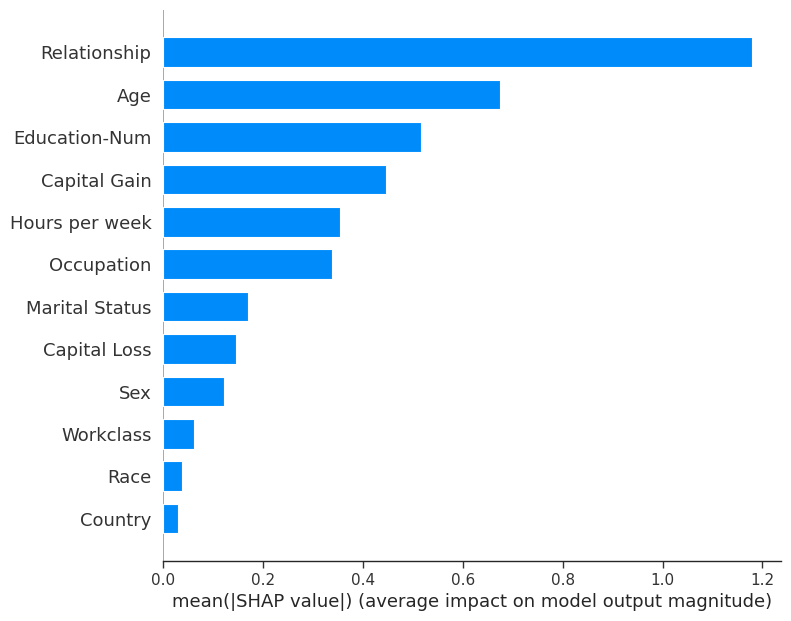

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

#### Explicación de un solo ejemplo con `force_plot` (gráfico de fuerzas)

* El gráfico de fuerzas muestra los shap values de una manera intuitiva, como flechas de fuerza "empujando" la predicción original (_base value_) hacia la predicción final (_f(x)_).

* El color rojo significa **impacto positivo** (aumento en las probabilidades de tener >50K)
* El color azul significa **impacto negativo** (reducción en las probabilidad de tener >50K).

_Nota: Se agregó la opción `link="logit"` para mostrar los valores en términos de probabilidades y no de logits.

In [ ]:
# Modificar para observar otras filas del dataset
i = 20000

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values=shap_values[i,:],
                features=X_display.iloc[i,:],
                link="logit")

In [ ]:
# Acá observamos en el ejemplo anterior, los valores que toma cada una de sus características
# Y el Shap value asociado a este 'i' que dicha característica tome dicho valor.
sample = X_display.iloc[[i]].T
sample['Shap Values'] = shap_values[i].round(2)
sample['Shap Values Abs'] = sample['Shap Values'].abs()
sample.sort_values('Shap Values Abs', ascending=False).drop('Shap Values Abs', axis=1)

,20000,Shap Values
Relationship,Husband,0.89
Occupation,Machine-op-inspct,-0.62
Education-Num,9.0,-0.52
Capital Gain,0.0,-0.19
Race,Black,-0.18
Hours per week,40.0,-0.10
Capital Loss,0.0,-0.08
Age,63.0,0.07
Marital Status,Married-civ-spouse,0.07
Sex,Male,0.05


In [ ]:
sample

,20000,Shap Values,Shap Values Abs
Age,63.0,0.07,0.07
Workclass,Private,-0.02,0.02
Education-Num,9.0,-0.52,0.52
Marital Status,Married-civ-spouse,0.07,0.07
Occupation,Machine-op-inspct,-0.62,0.62
Relationship,Husband,0.89,0.89
Race,Black,-0.18,0.18
Sex,Male,0.05,0.05
Capital Gain,0.0,-0.19,0.19
Capital Loss,0.0,-0.08,0.08


In [ ]:
# base_value: la predicción promedio del modelo, o bias
# El grafico de fuerzas muestra cuanto se aparta una predicción de la media general
model_xgboost.predict(dtrain).mean().round(4)

0.2427

#### Otro tipo de summary plot: beeswarm

El beeswarm muestra:
* La distribución de los datos para cada característica
* El impacto del valor que toma una característica sobre el resultado


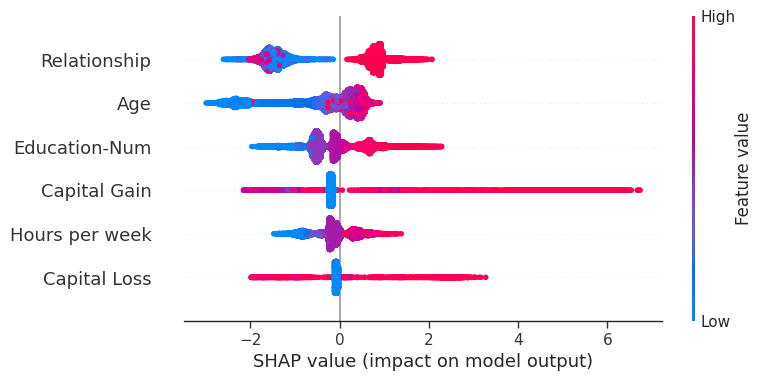

In [ ]:
# Age, Education-Num, Relationship, Capital Gain, Capital Loss, Hours per week
cols = [0, 2, 5, 8, 9, 10]
shap.summary_plot(shap_values[:, cols], X.iloc[:, cols])

#### Gráficos de dependencias

Los gráficos de dependencia muestran el efecto de un atributo específico a través de todo el conjunto de datos. Contrastan su valor con el valor SHAP de dicho atributo a través de muchos registros. Si bien son similares a los _Partial Dependency Plots_ (PDP), toman además en cuenta las interacciones entre los atributos, que se evidencia en la dispersión vertical en un determinado valor y en el color de la variable elegida a tal fin.

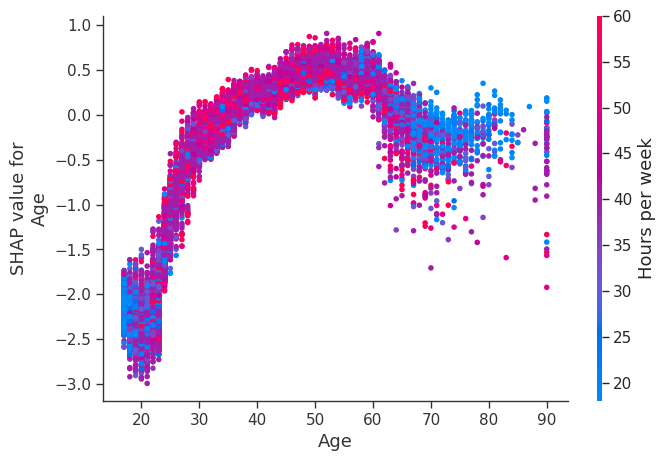

In [ ]:
shap.dependence_plot('Age', shap_values, X,
                     display_features=X_display, interaction_index=10)

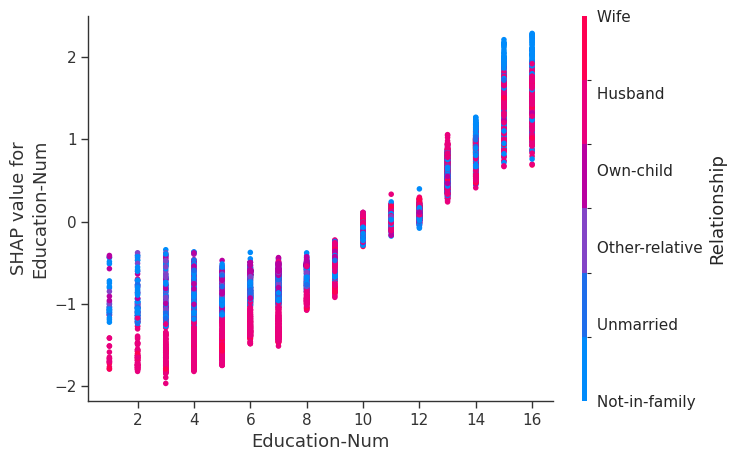

In [ ]:
shap.dependence_plot('Education-Num', shap_values, X,
                     display_features=X_display, interaction_index=5)

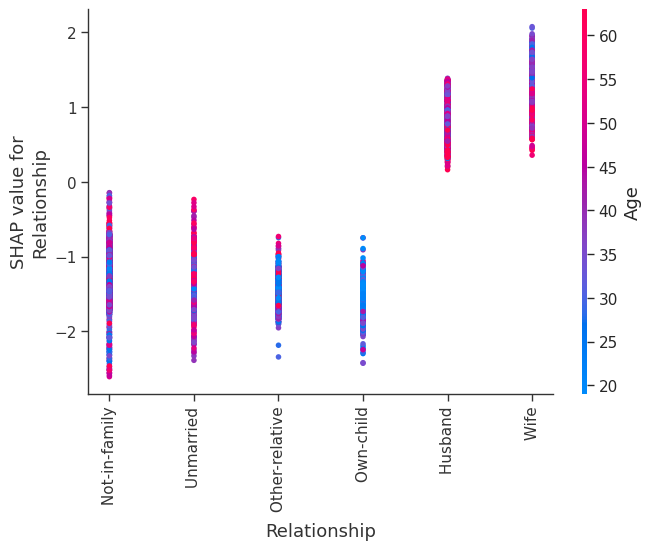

In [ ]:
shap.dependence_plot('Relationship', shap_values, X,
                     display_features=X_display, interaction_index=0)